In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import numpy as np
from IPython import display
from tensorboardX import SummaryWriter
import torchvision.utils as vutils

In [3]:
DATA_FOLDER = '/home/pushpull/mount/intHdd/dataset/'

In [4]:
def load_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [5]:
data = load_data()

In [6]:
class discriminator(torch.nn.Module):
    def __init__(self, parameter):
        super(discriminator, self).__init__()
        self.y = 1
        self.gan_out = parameter.get("gan_out")
        self.Network()
        
    def Network(self):
            self.hidden0 = nn.Sequential( 
                nn.Linear(self.gan_out, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
                ).cuda()
            self.hidden1 = nn.Sequential(
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
                ).cuda()
            self.hidden2 = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3)
                ).cuda()
            self.out = nn.Sequential(
                torch.nn.Linear(256, self.y),
                torch.nn.Sigmoid()
            ).cuda()
            
    def forward(self, x_):
            x_ = self.hidden0(x_)
            x_ = self.hidden1(x_)
            x_ = self.hidden2(x_)
            x_ = self.out(x_)
            return x_

In [7]:
class generator(torch.nn.Module):
    def __init__(self, parameter):
        super(generator, self).__init__()
        self.gan_out = parameter.get("gan_out")
        self.gan_in  = parameter.get("gan_in")
        self.Network()
        
    def Network(self):
            self.hidden0 = nn.Sequential(
                nn.Linear(self.gan_in, 256),
                nn.LeakyReLU(0.2)
            ).cuda()
            self.hidden1 = nn.Sequential(            
                nn.Linear(256, 512),
                nn.LeakyReLU(0.2)
            ).cuda()
            self.hidden2 = nn.Sequential(
                nn.Linear(512, 1024),
                nn.LeakyReLU(0.2)
            ).cuda()
        
            self.out = nn.Sequential(
                nn.Linear(1024, self.gan_out),
                nn.Tanh()
            ).cuda()
            
    def forward(self, x_):
            x_ = self.hidden0(x_)
            x_ = self.hidden1(x_)
            x_ = self.hidden2(x_)
            x_ = self.out(x_)
            return x_

In [8]:
def noise(length, size):
    noise = Variable(torch.randn(length, size)).cuda()
    return noise

In [9]:
def train_discriminator(discriminator, no_data, true_data, fake_data, gan_in, d_optimizer, loss):
    d_optimizer.zero_grad()
    
    prob_true  = discriminator(true_data)
    true_out   = Variable(torch.ones(no_data, 1)).cuda()
    error_true = loss(prob_true, true_out)
    error_true.backward()

    prob_false = discriminator(fake_data)
    false_out = Variable(torch.zeros(no_data, 1)).cuda()
    error_false = loss(prob_false, false_out)
    error_false.backward()
    
    d_optimizer.step()
    
    return (error_true + error_false)
    
    
    
    
    
def train_generator(generator, discriminator, no_data, fake_data, gan_in, g_optimizer, loss):
    g_optimizer.zero_grad()
    
    prob  = discriminator(fake_data)
    true_out   = Variable(torch.ones(no_data, 1)).cuda()
    error = loss(prob, true_out)
    error.backward()
    g_optimizer.step()
    
    return error
    
    

    
def sample(generator, sample_size, in_size, step):
    noise_input = noise(sample_size, in_size).cuda()
    output      = generator(noise_input).cpu().detach()
    plot_sample(output, sample_size, step)
    
    

    
def plot_sample(image, sample_size, step):
    image      = image.view(image.size(0), 1, 28, 28)
    grid = vutils.make_grid(image, nrow=int(np.sqrt(sample_size)), normalize=True, scale_each=True)
    fig = plt.figure(figsize=(sample_size, sample_size))
    location = "Step" + str(step)
    plt.imsave(location, np.moveaxis(grid.numpy(), 0, -1))
    plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
    display.display(plt.gcf())
    plt.close()
    
    
    
    
def train(parameter):
    no_epochs = parameter.get("no_epochs")
    gan_in  = parameter.get("gan_in")
    gan_out = parameter.get("gan_out")
    loss = parameter.get("loss")
    x = parameter.get("true_data")
    generator = parameter.get("generator")
    discriminator = parameter.get("discriminator")
    d_optimizer = parameter.get("d_optimizer")
    g_optimizer = parameter.get("g_optimizer")
    sample_size = parameter.get("sample_size")
    no_data = parameter.get("batch_size")
    
    step = 0
    g_error = []
    d_error = []
    n_error = []
    
    for epoch_no in range(no_epochs):
        for i, (data,_) in enumerate(x):
            
            true_data = data.view(batch_size, gan_out)
            true_data = Variable(true_data).cuda()
            fake_in_data = noise(no_data, gan_in)
            fake_data = generator(fake_in_data).detach()
            disc_error   = train_discriminator(discriminator, no_data, true_data, fake_data, gan_in, d_optimizer, loss)
            
            fake_in_data = noise(no_data, gan_in)
            fake_data = generator(fake_in_data)
            gen_error    = train_generator(generator, discriminator, no_data, fake_data, gan_in, g_optimizer, loss)
            
            error        = (gen_error + disc_error)
            
            g_error.append(gen_error)
            d_error.append(disc_error)
            n_error.append(error)
            
            if step%10 == 0:
                display.clear_output(True)
                print("Epoch Number:    ", epoch_no)
                print("Batch Number:    ", i)
            
                print("Generator Error        :    ", gen_error.item())
                print("Discriminator Error    :    ", disc_error.item())
                sample(generator, sample_size, gan_in, step)
                plt.plot(g_error)
                plt.show()
                plt.plot(d_error)
                plt.show()
                plt.plot(n_error)
                plt.show()
            step += 1

In [10]:
batch_size = 1000
d_layer_size = 3
d_layer      = [1024, 512, 256]
gan_out      = 784

parameter    = {"d_layer_size":d_layer_size,
                "d_layer":d_layer,
                "gan_out":gan_out}

In [11]:
disc = discriminator(parameter)

In [12]:
batch_size = 1000
g_layer_size = 3
g_layer      = [256, 512, 1024]
gan_in       = 100
gan_out      = 784

parameter    = {"d_layer_size":d_layer_size,
                "d_layer":d_layer,
                "g_layer_size":g_layer_size,
                "g_layer":g_layer,
                "gan_out":gan_out,
                "gan_in":gan_in}

In [13]:
x = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [14]:
gen = generator(parameter)

In [15]:
batch_size = 1000
no_epochs = 200
gan_in    = 100
gan_out   = 784
loss = nn.BCELoss()
true_data = x
d_optimizer = optim.Adam(disc.parameters(), lr=0.0002)
g_optimizer = optim.Adam(gen.parameters(), lr=0.0002)
sample_size = 9

parameter = {"batch_size":batch_size,
             "no_epochs":no_epochs,
             "gan_in":gan_in,
             "gan_out":gan_out,
             "loss":loss,
             "true_data":x,
             "generator":gen,
             "discriminator":disc,
             "d_optimizer":d_optimizer,
             "g_optimizer":g_optimizer,
             "sample_size":sample_size}

Epoch Number:     9
Batch Number:     30
Generator Error        :     0.5394706130027771
Discriminator Error    :     1.2897521257400513


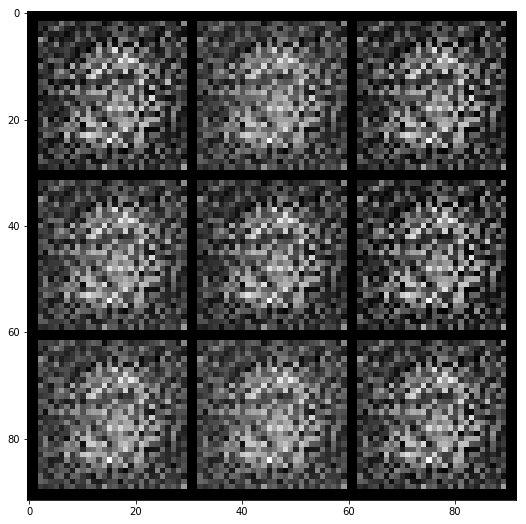

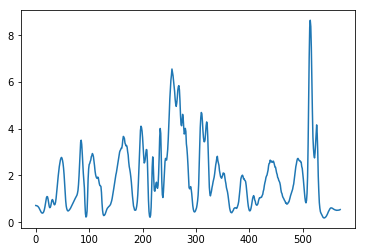

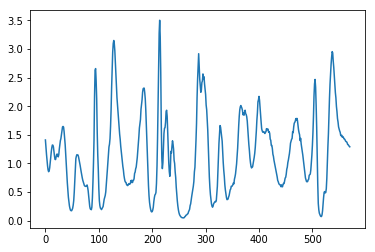

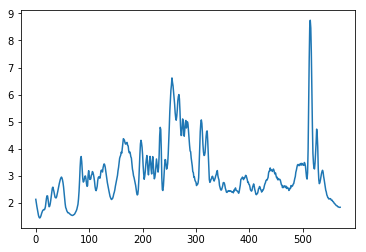

In [ ]:
train(parameter)